In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, ZeroPadding2D, GlobalAveragePooling2D, Activation, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/

In [5]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 133M/149M [00:00<00:00, 161MB/s]
100% 149M/149M [00:00<00:00, 169MB/s]


In [6]:
import zipfile
zip = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip.extractall("/content")
zip.close()

In [12]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [38]:
from tensorflow import keras
train_ds_resnet = keras.utils.image_dataset_from_directory(directory = train_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

validation_ds_resnet = keras.utils.image_dataset_from_directory(directory = test_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [39]:
def preprocess_resnet(image, label):   # To preprocess the pixel values

    image = preprocess_input(image)

    return image, label

train_ds_resnet.map(preprocess_resnet)
validation_ds_resnet.map(preprocess_resnet)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
conv_base_resnet = ResNet50(include_top=False,
                    weights = 'imagenet',
                    input_shape=(224,224,3))

conv_base_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [42]:
for layer in conv_base_resnet.layers:
    print(layer.name)

input_layer_2
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [43]:
# Unfreezing the last 5th stage layers to make those weights trainable

conv_base_resnet.trainable = False
set_trainable = False

for layer in conv_base_resnet.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True

    if set_trainable:
        layer.trainable = True

    else:
        layer.trainable = False

for layer in conv_base_resnet.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1

In [44]:
import tensorflow as tf

from tensorflow.keras.models import Model

# Creating a new model and adding fully connected layers
x = conv_base_resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax', name='fc1000')(x)

model = Model(inputs=conv_base_resnet.input, outputs=x)

In [45]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,280,132 (187.99 MB)

 Trainable params: 40,667,908 (155.14 MB)

 Non-trainable params: 8,612,224 (32.85 MB)

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

local_save_path = '/content/BEST_resnet50_pretrained2.keras'

os.makedirs(os.path.dirname(local_save_path), exist_ok=True)

checkpoint = ModelCheckpoint(filepath=local_save_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=False,
                              verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=6,
                                          verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               verbose=1,
                               patience=10)

callbacks = [checkpoint, reduce_learning_rate, early_stopping]

In [52]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
history = model.fit(train_ds, epochs=10,
                    batch_size=32,
                    validation_data = validation_ds,
                    verbose=1,
                    callbacks = callbacks)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9989 - loss: 0.0029
Epoch 1: val_loss did not improve from 0.06606
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.9989 - loss: 0.0029 - val_accuracy: 0.9756 - val_loss: 0.0776 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 2: val_loss did not improve from 0.06606
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9764 - val_loss: 0.0701 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 3: val_loss did not improve from 0.06606
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9794 - val_loss: 0.0665 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 7.2528e-04
Epoch 4: val_loss did not improve from 0.06606
179/179 ━━━━

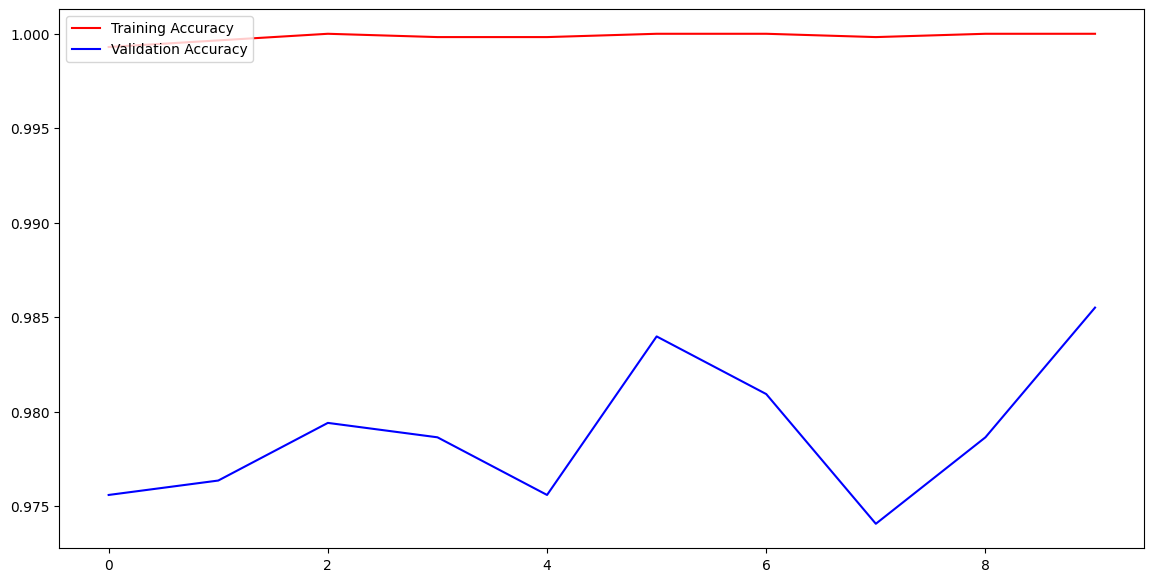

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

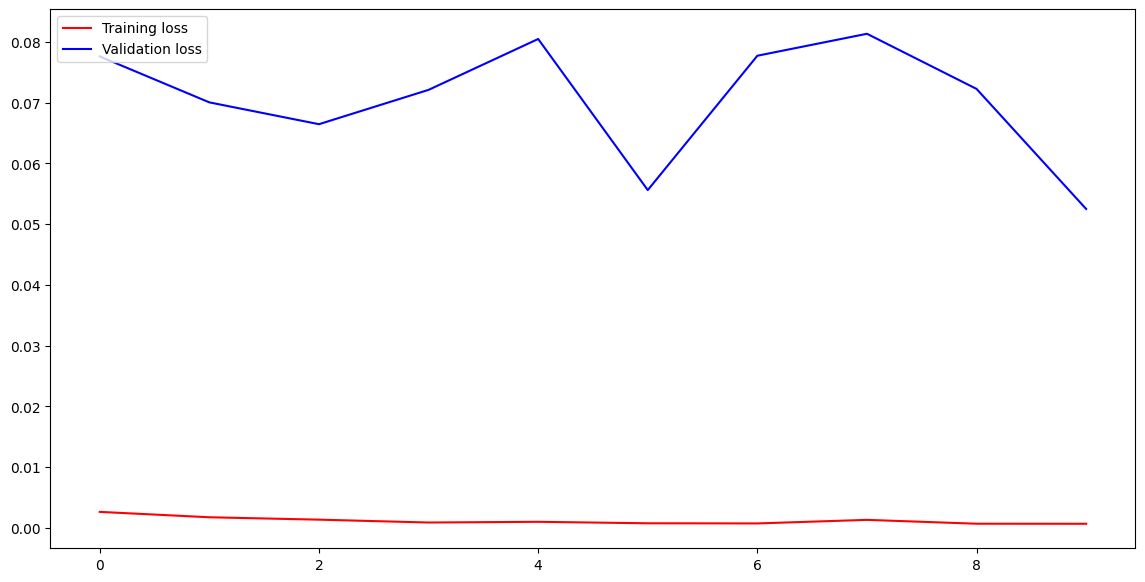

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [57]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/content/BEST_resnet50_pretrained2.keras')

predict_list = []
true_labels = []

for batch in validation_ds_resnet:

    images, labels = batch
    true_labels.extend(labels.numpy())

    for img in images:
        img_array = np.array(img)
        img_array = img_array.reshape(1, 224, 224, 3)

        pred = model.predict(img_array)

        indices = pred.argmax()

        predict_list.append(indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

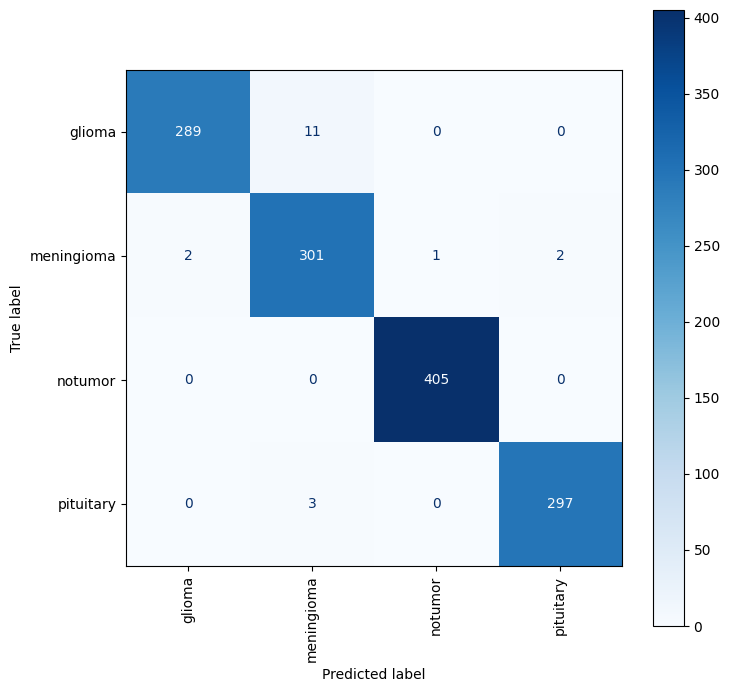

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(true_labels, predict_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predict_list))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       300
           1       0.96      0.98      0.97       306
           2       1.00      1.00      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311

